### Exercise 1 Data based modeling and control

#### Imports

In [48]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from control.matlab import tf, step, lsim


%matplotlib inline

#### Loading Matlab data 

In [49]:
mat_1 = scipy.io.loadmat("/home/matthias/WS_all/dbm/raw/ex1_handout/ex1_lsq_eqnerror_data2_step.mat")
mat_2 = scipy.io.loadmat("/home/matthias/WS_all/dbm/raw/ex1_handout/ex1_lsq_eqnerror_data1_step.mat")

for k in mat_1.keys():
    print(k)

for k in mat_2.keys():
    print(k)

__header__
__version__
__globals__
t2
u2
y2
__header__
__version__
__globals__
None
p
t
u
y
__function_workspace__


#### First look at data

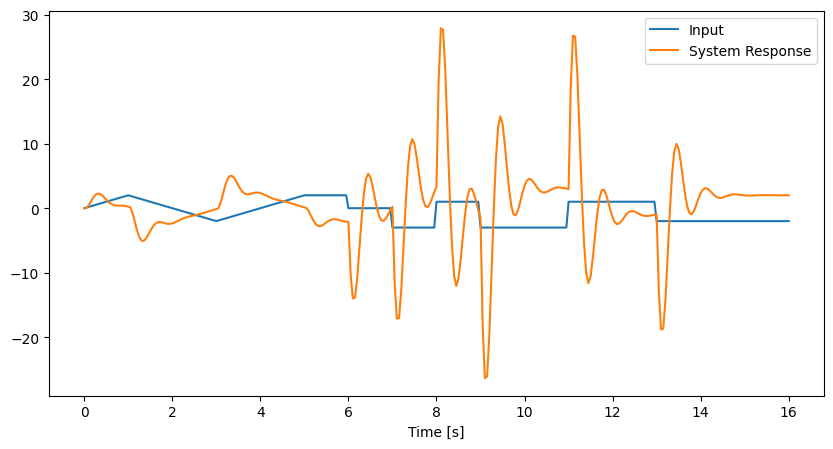

In [50]:
t2 = [e[0] for e in mat_1.get("t2").T]
u2 = [e[0] for e in mat_1.get("u2")]
y2 = [e[0] for e in mat_1.get("y2")]

plt.figure(figsize=(10, 5))
plt.plot(t2,u2, label="Input")
plt.xlabel("Time [s]")
plt.plot(t2, y2,label="System Response")
plt.legend()
plt.show()




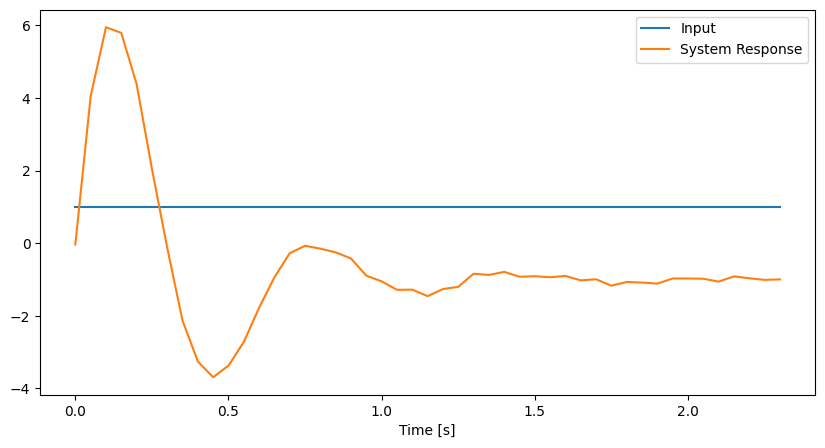

In [51]:
p = mat_2.get("p")
t = [e[0] for e in mat_2.get("t")]
u = [e[0] for e in mat_2.get("u")]
y = [e[0] for e in mat_2.get("y")]

plt.figure(figsize=(10, 5))
plt.plot(t,u, label="Input")
plt.xlabel("Time [s]")
plt.plot(t, y,label="System Response")
plt.legend()
plt.show()

#### Declaring constants

In [52]:
# Constants
Ts = 0.05
NA = 4
NB = 4

#### Creation of Model

In [53]:
def s_k(y:np.array,u:np.array,n_a,n_b, k):
    """ Construct the s_k vector
    
    Args:
        y (np.array): Output vector
        u (np.array): Input vector
        n_a (int): Order of the denominator
        n_b (int): Order of the numerator
        k (int): Current index
    
    Returns:
        np.array: s_k vector
    """
    
    s_a = list(np.zeros(n_a))
    s_b = list(np.zeros(n_b +1))
    
    for i in range(k+1):
        index_a:int = k - i -1

        index_b:int = k - i

        if index_a >= 0:
            try:
                s_a[index_a] = float(y[i])
            except Exception:
                pass
        if index_b >= 0:
            try:
                s_b[index_b] = float(u[i])
            except Exception as e:
                pass
    
    s = s_a + s_b
    return s


S_K = [s_k(y,u,NA,NB,k) for k in range(len(y))]

S_K = np.array(S_K)

In [54]:
p_hat = np.matmul(np.linalg.pinv(S_K),y)

In [55]:
Gest = tf(p_hat[NA:], [1] + [-e for e  in p_hat[:NA]], Ts)

y_test, test = step(Gest, T=t)
y_out, _, x_out = lsim(Gest, u2, T=t2)

/home/matthias/.local/lib/python3.10/site-packages/control/timeresp.py:1083: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


#### Plot Results of step response

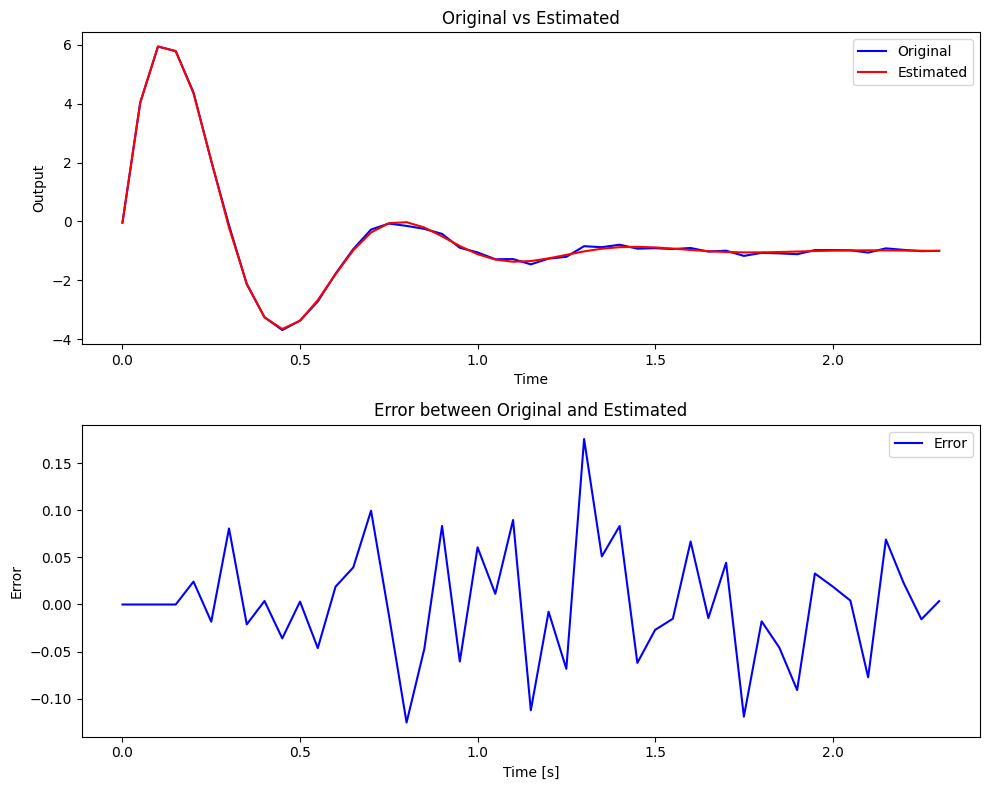

In [56]:
fig, ax = plt.subplots(2,1,figsize=(10, 8))

ax[0].plot(t, y, 'b-', label='Original')
ax[0].plot(t, y_test, 'r-', label='Estimated')
ax[0].legend()
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Output')
ax[0].set_title('Original vs Estimated')

ax[1].plot(t, (y - y_test), 'b-', label='Error')
ax[1].legend()
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Error')
ax[1].set_title('Error between Original and Estimated')
plt.tight_layout()
plt.show()

#### Plot results of validation set

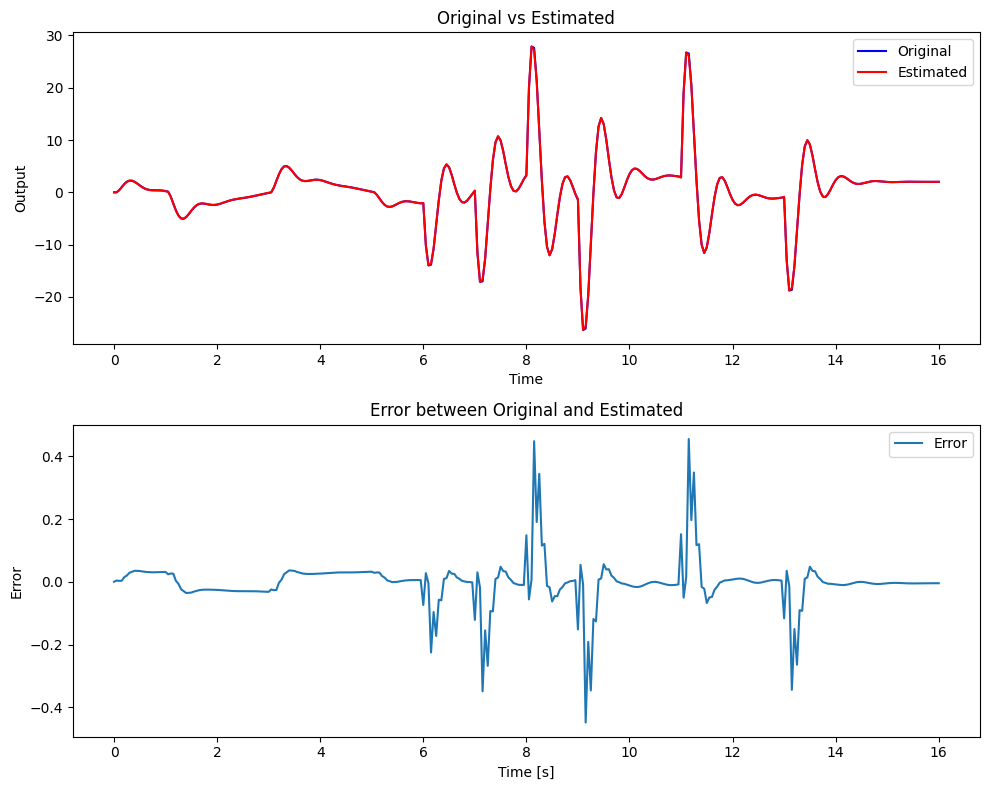

In [57]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(t2, y2, 'b-', label='Original')
axs[0].plot(t2, y_out, 'r-', label='Estimated')
axs[0].legend()
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Output')
axs[0].set_title('Original vs Estimated')

axs[1].plot(t2, (y2 - y_out), label="Error")
axs[1].legend()
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Error')
axs[1].set_title('Error between Original and Estimated')

plt.tight_layout()
plt.show()

In [58]:
display(p_hat)
display(p_hat[NA:])
display(p_hat[:NA])

display(len(p_hat[NA:])) 
display(len(p_hat[:NA])) 

array([ 0.51531293,  0.57258489, -0.38584953, -0.17829461, -0.03970147,
        4.10243333, -0.17472588, -3.49184919, -0.87351989])

array([-0.03970147,  4.10243333, -0.17472588, -3.49184919, -0.87351989])

array([ 0.51531293,  0.57258489, -0.38584953, -0.17829461])

5

4